In [16]:
import tensorflow as tf
from tensorflow.keras import layers

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('dark_background')
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D

from custom_lstm import CustomLSTM

#Tries to enable dynamic memory allocation on GP
try:
	for i in tensorflow.config.experimental.list_physical_devices("GPU"):
		tensorflow.config.experimental.set_memory_growth(i, True)
except:
	print("Device dynamic memory allocation failed!")


Device dynamic memory allocation failed!


In [17]:

df_train = pd.read_csv('train.tsv', sep='\t')
print('train set: {0}'.format(df_train.shape))
df_train.head(10)

train set: (156060, 4)


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


In [18]:
df_test = pd.read_csv('test.tsv', sep='\t')
print('test set: {0}'.format(df_test.shape))
df_test.head(10)

test set: (66292, 3)


,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine
5,156066,8545,intermittently pleasing but
6,156067,8545,intermittently pleasing
7,156068,8545,intermittently
8,156069,8545,pleasing
9,156070,8545,but


In [19]:
replace_list = {r"i'm": 'i am',
                r"'re": ' are',
                r"let’s": 'let us',
                r"'s":  ' is',
                r"'ve": ' have',
                r"can't": 'can not',
                r"cannot": 'can not',
                r"shan’t": 'shall not',
                r"n't": ' not',
                r"'d": ' would',
                r"'ll": ' will',
                r"'scuse": 'excuse',
                ',': ' ,',
                '.': ' .',
                '!': ' !',
                '?': ' ?',
                '\s+': ' '}
def clean_text(text):
    text = text.lower()
    for s in replace_list:
        text = text.replace(s, replace_list[s])
    text = ' '.join(text.split())
    return text

In [20]:
X_train = df_train['Phrase'].apply(lambda p: clean_text(p))

max phrase len: 53


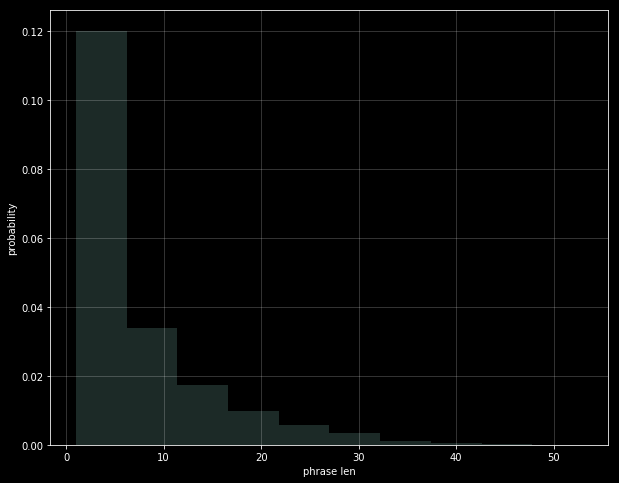

In [21]:
phrase_len = X_train.apply(lambda p: len(p.split(' ')))
max_phrase_len = phrase_len.max()
print('max phrase len: {0}'.format(max_phrase_len))
plt.figure(figsize = (10, 8))
plt.hist(phrase_len, alpha = 0.2, density = True)
plt.xlabel('phrase len')
plt.ylabel('probability')
plt.grid(alpha = 0.25)

In [22]:
y_train = df_train['Sentiment']

In [23]:
max_words = 8192
tokenizer = Tokenizer(
    num_words = max_words,
    filters = '"#$%&()*+-/:;<=>@[\]^_`{|}~'
)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen = max_phrase_len)
y_train = to_categorical(y_train)

In [24]:
batch_size = 512
epochs = 8

lstm = CustomLSTM(2, dropout = 0.3, recurrent_dropout = 0.3)

In [29]:
model_lstm = tf.keras.Sequential()
model_lstm.add(layers.Embedding(input_dim = max_words, output_dim = 2, input_length = max_phrase_len))
model_lstm.add(layers.SpatialDropout1D(0.3))
model_lstm.add(lstm)
model_lstm.add(layers.Dense(2, activation = 'relu'))
model_lstm.add(layers.Dropout(0.3))
model_lstm.add(layers.Dense(5, activation = 'softmax'))

model_lstm.compile(
    loss='categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)

model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 53, 2)             16384     
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 53, 2)             0         
_________________________________________________________________
custom_lstm (CustomLSTM)     (None, 2)                 40        
_________________________________________________________________
dense (Dense)                (None, 2)                 6         
_________________________________________________________________
dropout (Dropout)            (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 15        
Total params: 16,445
Trainable params: 16,445
Non-trainable params: 0
__________________________________________________

In [30]:
for l in model_lstm.layers:
    print (l.name ,l.input_shape,l.output_shape)

embedding_2 (None, 53) (None, 53, 2)
spatial_dropout1d_1 (None, 53, 2) (None, 53, 2)
custom_lstm (None, 53, 2) (None, 2)
dense (None, 2) (None, 2)
dropout (None, 2) (None, 2)
dense_1 (None, 2) (None, 5)


In [31]:
lstm.get_weights()

[array([[-0.591419  ,  0.59484255, -0.35375634,  0.46114802, -0.5805067 ,
          0.4047637 , -0.7558376 ,  0.4828446 ],
        [-0.6566859 , -0.72169894,  0.23701644,  0.22687519, -0.31008863,
         -0.70755607, -0.6843496 , -0.6154559 ]], dtype=float32),
 array([[ 0.63774896,  0.04140596, -0.06741163,  0.14358753,  0.19786666,
          0.6404545 , -0.24577598,  0.23803549],
        [-0.00642303,  0.26894662,  0.11315306, -0.15488932, -0.3287952 ,
          0.14186859, -0.6012627 , -0.6333106 ]], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)]

In [32]:
lstm.weights

[<tf.Variable 'custom_lstm/kernel1:0' shape=(2, 8) dtype=float32, numpy=
 array([[-0.591419  ,  0.59484255, -0.35375634,  0.46114802, -0.5805067 ,
          0.4047637 , -0.7558376 ,  0.4828446 ],
        [-0.6566859 , -0.72169894,  0.23701644,  0.22687519, -0.31008863,
         -0.70755607, -0.6843496 , -0.6154559 ]], dtype=float32)>,
 <tf.Variable 'custom_lstm/recurrent_kernel1:0' shape=(2, 8) dtype=float32, numpy=
 array([[ 0.63774896,  0.04140596, -0.06741163,  0.14358753,  0.19786666,
          0.6404545 , -0.24577598,  0.23803549],
        [-0.00642303,  0.26894662,  0.11315306, -0.15488932, -0.3287952 ,
          0.14186859, -0.6012627 , -0.6333106 ]], dtype=float32)>,
 <tf.Variable 'custom_lstm/bias:0' shape=(8,) dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>]

In [33]:
history = model_lstm.fit(
    X_train,
    y_train,
    validation_split = 0.1,
    epochs = 8,
    batch_size = 512
)

Train on 140454 samples, validate on 15606 samples
Epoch 1/8
140454/140454 [==============================] - 12s 88us/sample - loss: 1.4662 - accuracy: 0.4101 - val_loss: 1.3014 - val_accuracy: 0.4880
Epoch 2/8
140454/140454 [==============================] - 7s 47us/sample - loss: 1.2884 - accuracy: 0.5124 - val_loss: 1.2544 - val_accuracy: 0.4880
Epoch 3/8
140454/140454 [==============================] - 6s 44us/sample - loss: 1.2498 - accuracy: 0.5124 - val_loss: 1.2330 - val_accuracy: 0.4880
Epoch 4/8
140454/140454 [==============================] - 6s 46us/sample - loss: 1.2281 - accuracy: 0.5124 - val_loss: 1.2188 - val_accuracy: 0.4880
Epoch 5/8
140454/140454 [==============================] - 7s 48us/sample - loss: 1.2149 - accuracy: 0.5124 - val_loss: 1.2104 - val_accuracy: 0.4880
Epoch 6/8
140454/140454 [==============================] - 7s 53us/sample - loss: 1.2056 - accuracy: 0.5124 - val_loss: 1.2047 - val_accuracy: 0.4880
Epoch 7/8
140454/140454 [=======================

In [34]:
model_lstm.layers[2].get_weights()

[array([[-0.36962855, -0.04198382,  0.836913  ,  1.8289781 , -1.6919007 ,
          1.8691338 , -0.04572856,  1.1362066 ],
        [-0.87697756,  0.0589328 , -1.0058402 , -0.9918448 ,  0.86087835,
         -2.1112318 , -1.5263712 , -1.220139  ]], dtype=float32),
 array([[ 0.20922768, -1.1778432 , -0.27241588,  0.05702753,  0.44663513,
          0.07623804, -0.63816726, -0.6755149 ],
        [ 0.11539712,  0.9815479 ,  0.13501714, -0.6695727 , -0.2507623 ,
          0.25536495,  0.07591886,  0.22127455]], dtype=float32),
 array([ 0.48617488,  1.0241948 ,  0.5525146 ,  0.7557503 , -0.01282689,
         0.02408813,  0.6065603 ,  1.155093  ], dtype=float32)]